In [1]:
# https://github.com/comocheng/autoscience_workflow/blob/main/analysis/make_sp_delay_npys.py

# monte carlo sampling example
# https://github.com/comocheng/autoscience_workflow/blob/main/monte_carlo_sampling/run_all_sims.py

In [33]:
import os
import sys
import time
import copy
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import rmgpy.chemkin
import subprocess


import matplotlib.pyplot as plt
%matplotlib inline

In [34]:

def plot_thermos(thermos, labels=None):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
    linestyles = ['solid', 'dashed', 'dotted']
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 1500, 1001)
    for m, thermo in enumerate(thermos):
        if 'cantera' in str(type(thermo)).lower() and hasattr(thermo, 'thermo'):
            thermo = thermo.thermo
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        if 'rmgpy' in str(type(thermo)).lower():
            for i in range(0, len(T)):
                H[i] = thermo.get_enthalpy(T[i]) / 1000.0
                S[i] = thermo.get_entropy(T[i]) / 1000.0
                Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        else:  # cantera
            for i in range(0, len(T)):
                H[i] = thermo.h(T[i]) / 1e6  # J/kmol
                S[i] = thermo.s(T[i]) / 1e6
                Cp[i] = thermo.cp(T[i]) / 1e6  # J/mol K
        ax[0].plot(T, H, linestyle=linestyles[m % len(linestyles)])
        ax[1].plot(T, S, linestyle=linestyles[m % len(linestyles)])
        ax[2].plot(T, Cp, linestyle=linestyles[m % len(linestyles)])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    ax[2].yaxis.get_major_formatter().set_useOffset(False)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [35]:
mech_path = './mech1/'
chemkin_file = os.path.join(mech_path, 'chem_annotated.inp')
species_dict = os.path.join(mech_path, 'species_dictionary.txt')
transport_file = os.path.join(mech_path, 'tran.dat')


In [56]:
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_file, species_dict, transport_path=transport_file)

In [37]:
print(species_list[0].thermo.polynomials[0])

NASAPolynomial(coeffs=[2.5,-2.06855e-14,2.66266e-17,-1.11497e-20,1.43542e-24,-745,4.3663], Tmin=(100,'K'), Tmax=(4561.14,'K'))


In [38]:
my_copy = copy.deepcopy(species_list[0].thermo)

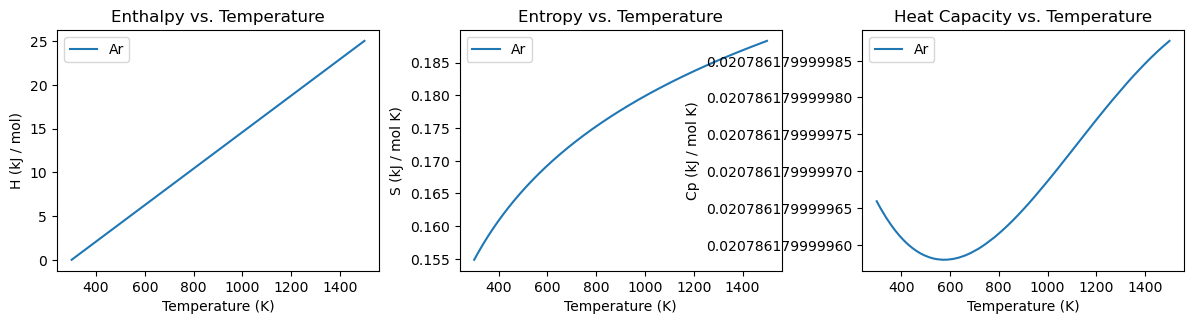

In [39]:
plot_thermos([species_list[0]], [str(species_list[0])])

In [43]:
my_copy.poly1.c5 += 418

In [40]:
my_copy.polynomials[0].coeffs[5] += 418

In [45]:
my_copy.polynomials

[NASAPolynomial(coeffs=[2.5,-2.06855e-14,2.66266e-17,-1.11497e-20,1.43542e-24,-327,4.3663], Tmin=(100,'K'), Tmax=(4561.14,'K')),
 NASAPolynomial(coeffs=[2.50002,-1.64942e-08,5.30955e-12,-7.59275e-16,4.06972e-20,-745.018,4.36618], Tmin=(4561.14,'K'), Tmax=(5000,'K'))]

In [41]:
print(my_copy.polynomials[0])

NASAPolynomial(coeffs=[2.5,-2.06855e-14,2.66266e-17,-1.11497e-20,1.43542e-24,-745,4.3663], Tmin=(100,'K'), Tmax=(4561.14,'K'))


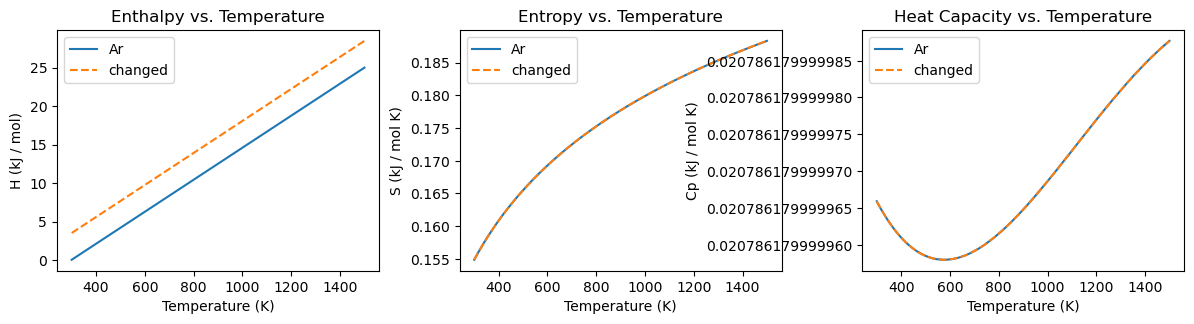

In [44]:
plot_thermos([species_list[0], my_copy], [str(species_list[0]), 'changed'])

0

NASA(polynomials=[NASAPolynomial(coeffs=[2.5,-2.06855e-14,2.66266e-17,-1.11497e-20,1.43542e-24,-745,4.3663], Tmin=(100,'K'), Tmax=(4561.14,'K')), NASAPolynomial(coeffs=[2.50002,-1.64942e-08,5.30955e-12,-7.59275e-16,4.06972e-20,-745.018,4.36618], Tmin=(4561.14,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo library: BurkeH2O2""")


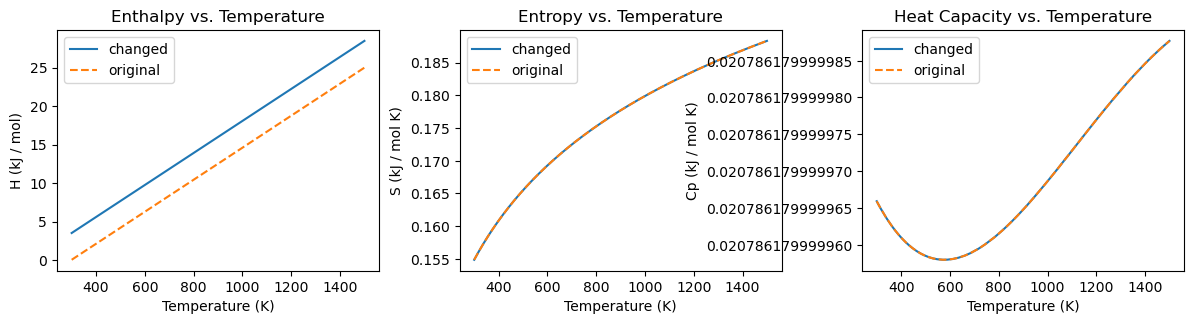

Wrote YAML mechanism file to 'chem_0000.yaml'.
Mechanism contains 124 species and 1896 reactions.
Validating mechanism...
PASSED


1

NASA(polynomials=[NASAPolynomial(coeffs=[2.5,-2.06855e-14,2.66266e-17,-1.11497e-20,1.43542e-24,-745,0.914222], Tmin=(100,'K'), Tmax=(4561.14,'K')), NASAPolynomial(coeffs=[2.50002,-1.64942e-08,5.30955e-12,-7.59275e-16,4.06972e-20,-745.018,0.914099], Tmin=(4561.14,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo library: BurkeH2O2""")


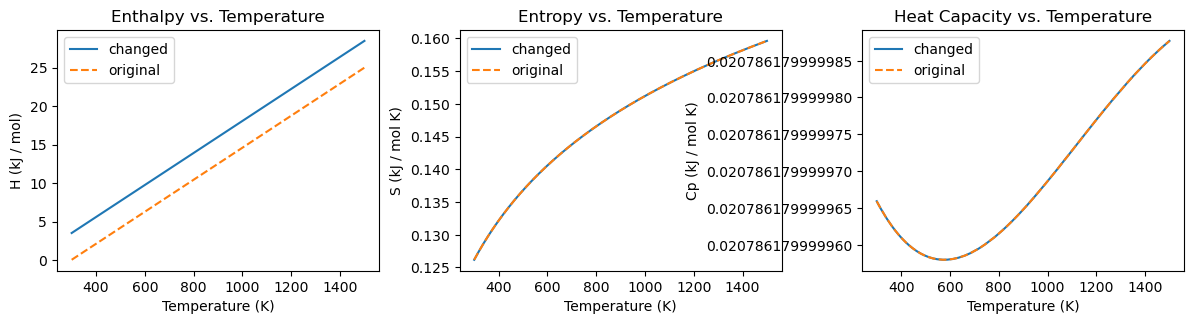

Wrote YAML mechanism file to 'chem_0001.yaml'.
Mechanism contains 124 species and 1896 reactions.
Validating mechanism...
PASSED


In [58]:
for i in range(len(species_list)):
    display(i, species_list[i])
    
    print(species_list[i].thermo)
    
    original_thermo = copy.deepcopy(species_list[i].thermo)

    species_list[i].thermo.poly1.c5 += 418
    species_list[i].thermo.poly2.c5 += 418
    
    plot_thermos([species_list[i], original_thermo], ['changed', 'original'])
    
    # run simulation 
    perturbed_chemkin = f'chem_{i:04}.inp'
    perturbed_yaml_path = perturbed_chemkin.replace('.inp', '.yaml')
    rmgpy.chemkin.save_chemkin_file(perturbed_chemkin, species_list, reaction_list, verbose=True, check_for_duplicates=True)
    subprocess.run(['ck2yaml', f'--input={perturbed_chemkin}', f'--transport={transport_file}', f'--output={perturbed_yaml_path}'])
    
    # Reset the mechanism
    species_list[i].thermo = original_thermo
    
    
    if i > 0:
        break

In [ ]:
for 